In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 6.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=14527f53f8f3f3582f0967c5ee99472d59a70b4033882a6a8cffa7acdb36b28b
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from spacy.lang.en import English
import csv
import gensim.downloader
import pretty_midi
from gensim.models import KeyedVectors
import pickle
import random
import matplotlib.pyplot as plt


In [9]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/'

In [10]:
train_path = data_path + 'lyrics_train_set.csv'
test_path = data_path + 'lyrics_test_set.csv'
mid_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/midi_files/'

In [6]:
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [7]:
def read_file(path):
    nlp = English()
    train = pd.read_csv(path)
    train = train.iloc[:, :3]
    print(train.shape)

    artists, song_names, lyrics = [], [], []
    with open(path, newline='') as f:
        lines = csv.reader(f, delimiter=',', quotechar='|')
        for row in lines:
            artists.append(row[0])
            song_name = row[1]
            if song_name[0] == " ":
                song_name = song_name[1:]
            song_names.append(song_name)
            tokenizer = nlp
            text = row[2]
            from_reg = ["`", "'re", "'s", "'d", "'ve", "'ll", "'m", "n't", "he'will", "ya'will", "i'will", "'em",
                        "you'will", "we'will", "lovin'", "'cause", "it'will", "they'will", "this'will", "'bout",
                        "y'awill", "nothin'", "somethin'", "doin'", ]
            to_reg = ["'", " are", " is", " had", " have", " will", " am", "not", "he will", "you will", "i will",
                      " them", "you will", "love", " because", "it will", "they will", "going", "this will", " about",
                      "you will", "nothing", "something", "doing"]
            _ = dict(zip(from_reg, to_reg))
            for k, v in _.items():
                text = text.replace(k, v)
            doc = tokenizer(text)
            tokens = [token for token in doc]
            token_list = []
            for token in tokens:
                if token.text.isalpha():
                    token_list.append(token.text)
                elif token.text == '&':
                    token_list.append('<NewLine>')
            lyrics.append(token_list)
    return {'artists': artists, 'song_names': song_names, 'lyrics': lyrics}


def create_vocabulary(train_df, test_df, w2v=w2v):
    vocabulary = dict()
    inverse_vocabulary = ['<unk>']
    lyrics_train = []
    lyrics_test = []
    embeddings = w2v
    for index_data, lyrics in enumerate([train_df, test_df]):
        for index, lyric in enumerate(lyrics['lyrics']):
            lyric_words = []
            for word in lyric:
                if word not in embeddings:
                    continue
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    lyric_words.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    lyric_words.append(vocabulary[word])

            if index_data == 0:
                lyrics_train.append(lyric_words)
            else:
                lyrics_test.append(lyric_words)
    return vocabulary, inverse_vocabulary, lyrics_train, lyrics_test



def get_songs_names():
    songs_names = dict()
    for file_name in os.listdir(mid_path):
        splited = file_name.split('_-_')
        artist_name = splited[0].replace('_', ' ').lower()

        song_name = splited[1].replace('.mid', '')
        song_name = song_name.replace('_', ' ').lower()

        songs_names[(song_name, artist_name)] = 0
    return songs_names


def get_songs_with_melody(lyrics, dic):
    songs_names = get_songs_names()
    songs_with_melody = {'artists': [], 'song_names': [], 'lyrics': []}
    all_songs = {'artists': [], 'song_names': [], 'lyrics': []}

    inserted_songs = dict()
    k = 0
    for _ in dic['artists']:
        song_name = dic['song_names'][k]
        artist_name = dic['artists'][k]

        if (song_name, artist_name) not in inserted_songs:
            inserted_songs[(song_name, artist_name)] = 0
        else:
            k += 1
            continue
        if (song_name, artist_name) in songs_names:
            songs_with_melody['artists'].append(artist_name)
            songs_with_melody['song_names'].append(song_name)
            songs_with_melody['lyrics'].append(lyrics[k])

        all_songs['artists'].append(artist_name)
        all_songs['song_names'].append(song_name)
        all_songs['lyrics'].append(lyrics[k])
        k += 1

    return songs_with_melody, all_songs


def get_midi(songs_with_melody):
    new_dict = {'artists': [], 'song_names': [], 'lyrics': []}

    midi_dict_keys = dict()
    midi_files = dict()
    for file_name in os.listdir(mid_path):
        song_name_midi = file_name.lower()
        midi_dict_keys[song_name_midi] = file_name

    artists_name = songs_with_melody['artists']
    song_name = songs_with_melody['song_names']
    lyrics = songs_with_melody['lyrics']

    i = 0
    while i < len(artists_name):
        file_name = f'{artists_name[i]}_-_{song_name[i]}.mid'.replace(" ", "_")
        try:
            pretty_midi_format = pretty_midi.PrettyMIDI(mid_path + midi_dict_keys[file_name])
            midi_files[file_name] = pretty_midi_format
            new_dict['artists'].append(artists_name[i])
            new_dict['song_names'].append(song_name[i])
            new_dict['lyrics'].append(lyrics[i])
            i += 1
        except:
            i += 1
            continue

    return midi_files, new_dict


def midi_features(songs_with_melody, midi_files):
    artists = songs_with_melody['artists']
    song_names = songs_with_melody['song_names']
    lyrics = songs_with_melody['lyrics']
    mid_features = dict()

    for index, item in enumerate(artists):
        artist = artists[index]
        song_name = song_names[index]
        lyric = lyrics[index]

        file_name = f'{artist}_-_{song_name}.mid'.replace(" ", "_")
        mid_file = midi_files[file_name]
        mid_features[(artist, song_name)] = []

        words_info = {}
        num_of_words = len(lyric)
        duration = mid_file.get_end_time()
        average_time_per_word = duration / num_of_words
        for index, word in enumerate(lyric):
            start = index * average_time_per_word
            end = start + average_time_per_word
            pitch_n, velocity_n, pitch, velocity, num_of_instruments, beats = 0, 0, 0, 0, 0, 0
            for instrument in mid_file.instruments:
                isEntered = False
                has_drum = 0
                for note in instrument.notes:
                    if start <= note.start and note.end <= end:
                        pitch_n += 1
                        velocity_n += 1
                        pitch += note.pitch
                        velocity += note.velocity
                        isEntered = True
                        if has_drum == 0:
                            if instrument.is_drum:
                                has_drum = 1
                if isEntered:
                    num_of_instruments += 1

            for beat in mid_file.get_beats():
                if start <= beat <= end:
                    beats += 1
                elif beat > end:
                    break

            if pitch_n == 0:
                avg_pitch = 0
            else:
                avg_pitch = pitch / pitch_n
            if velocity_n == 0:
                avg_velocity = 0
            else:
                avg_velocity = velocity / velocity_n
            # mid_features[(artist,song_name)][word] = [avg_velocity,avg_pitch,num_of_instruments,has_drum,beats]
            mid_features[(artist, song_name)].append([avg_velocity, avg_pitch, num_of_instruments, has_drum, beats])
    return mid_features


Creating and loading the train and test sets (we already created them, then load them from the drive to save space and running times)

In [11]:
train = read_file(train_path)
test = read_file(test_path)
vocabulary, inverse_vocabulary, lyrics_train, lyrics_test = create_vocabulary(train, test)
songs_with_melody_train, all_songs_train = get_songs_with_melody(lyrics_train, train)
songs_with_melody_test, all_songs_test = get_songs_with_melody(lyrics_test, test)

(599, 3)
(4, 3)


In [12]:
# midi_files, train_data = get_midi(songs_with_melody_train)
# train_features = midi_features(train_data, midi_files)

# midi_files, test_data = get_midi(songs_with_melody_test)
# test_features = midi_features(test_data, midi_files)

# with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW/3/DATA/test_midi_features.pickle", "wb") as handle:
#     pickle.dump(features, handle)
# with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW/3/DATA/test_data.pickle", "wb") as handle:
#     pickle.dump(test_data, handle)

# with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW/3/DATA/vocabulary.pickle", "wb") as handle:
#     pickle.dump(vocabulary, handle)
# with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning/HW/3/DATA/inverse_vocabulary.pickle", "wb") as handle:
#     pickle.dump(inverse_vocabulary, handle)

In [13]:
train_data, train_midi_features= None, None
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/train_data.pickle", "rb") as handle:
    train_data = pickle.load(handle)
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/train_midi_features.pickle", "rb") as handle:
    train_midi_features = pickle.load(handle)

test_data, test_midi_features = None, None
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/test_data.pickle", "rb") as handle:
    test_data = pickle.load(handle)
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/test_midi_features.pickle", "rb") as handle:
    test_midi_features = pickle.load(handle)

vocabulary, inverse_vocabulary = None, None
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/vocabulary.pickle", "rb") as handle:
    vocabulary=pickle.load(handle)
with open("/content/drive/MyDrive/Colab_Notebooks/Deep Learning/HW/3/DATA/inverse_vocabulary.pickle", "rb") as handle:
    inverse_vocabulary=pickle.load(handle)

In [14]:
class MyDataset(Dataset):
    def __init__(self, data, w2v_model, vocab, inv_vocab, midi):

        self.data = data # dict[artists, song_names, lyrics]
        self.w2v = w2v_model # word -> embeddings
        self.vocab = vocab # word -> index
        self.inv_vocab = inv_vocab # index -> word
        self.midi = midi # (artist, song) -> [<5 features>,...] == len(lyrics)
        self.inv_embds = {}
        self.embds = self.embeddings()


    def embeddings(self):
      embds = ['<unk>']
      for word in self.inv_vocab:
        if word not in self.w2v:
          continue
        embd = self.w2v[word]
        embds.append(embd)
        self.inv_embds[tuple(embd)] = word
      return embds

    def __len__(self):
        return len(self.data['lyrics'])

    def __getitem__(self, idx):
        artist, song, lyrics = self.data['artists'][idx], self.data['song_names'][idx], self.data['lyrics'][idx]
        lyrics_embeddings =  lyrics.copy()
        lyrics_embeddings = [self.embds[word] for word in lyrics_embeddings]
        x = torch.stack([torch.cat([torch.tensor(word), torch.tensor(midi)], dim=-1) for word, midi in zip(lyrics_embeddings, self.midi[(artist, song)])])

        return x, torch.tensor(lyrics)



In [15]:
train_dataset = MyDataset(data=train_data, w2v_model=w2v, vocab=vocabulary, inv_vocab=inverse_vocabulary, midi=train_midi_features)


In [16]:
test_dataset = MyDataset(data=test_data, w2v_model=w2v, vocab=vocabulary, inv_vocab=inverse_vocabulary, midi=test_midi_features)


In [17]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers=1,
                 dropout=0.3):
        super(MyModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.hn = None

        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h=None, return_state=False):

        if self.hn is None:
          self.hn = torch.zeros((self.num_layers, x.size(0), self.hidden_size))

        out, h = self.gru(x, h)
        self.hn = h#
        out = self.dropout(out)
        logits = self.linear(out)

        if return_state:
            return logits, h
        else:
            return logits

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [20]:
embedding_size = train_dataset[0][0].shape[1]
model = MyModel(input_size=embedding_size,  hidden_size=1024, vocab_size=len(train_dataset.inv_vocab)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def train(model, criterion, optimizer, train_dataloader, device, epoches):

    model.train()
    total_loss = []


    for epoch in range(epoches):

        for step, batch in enumerate(train_dataloader):
            x = batch[0].to(device)
            y = batch[1].to(device)

            preds = model(x)
            loss = criterion(preds.transpose(-1, -2), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'epoch: {epoch}, loss: {loss}')
        total_loss.append(loss)

    return model, total_loss

In [22]:
model, total_loss = train(model, criterion, optimizer, train_dataloader, device, epoches=25)

epoch: 0, loss: 0.9784114956855774
epoch: 1, loss: 1.059675693511963
epoch: 2, loss: 0.04397760331630707
epoch: 3, loss: 0.007161071058362722
epoch: 4, loss: 0.01797943189740181
epoch: 5, loss: 0.0028226329013705254
epoch: 6, loss: 0.0020630641374737024
epoch: 7, loss: 0.00261990656144917
epoch: 8, loss: 0.0014096422819420695
epoch: 9, loss: 0.0029089937452226877
epoch: 10, loss: 0.0021439609117805958
epoch: 11, loss: 0.0009786490118131042
epoch: 12, loss: 0.002050944836810231
epoch: 13, loss: 0.005705727729946375
epoch: 14, loss: 0.00025428630760870874
epoch: 15, loss: 0.00028393114916980267
epoch: 16, loss: 0.00020758954633492976
epoch: 17, loss: 0.004070703871548176
epoch: 18, loss: 0.006968711037188768
epoch: 19, loss: 0.00018073788669425994
epoch: 20, loss: 0.0011011379538103938
epoch: 21, loss: 5.2119154133833945e-05
epoch: 22, loss: 0.0003174103330820799
epoch: 23, loss: 0.00045394033077172935
epoch: 24, loss: 0.00025962587096728384


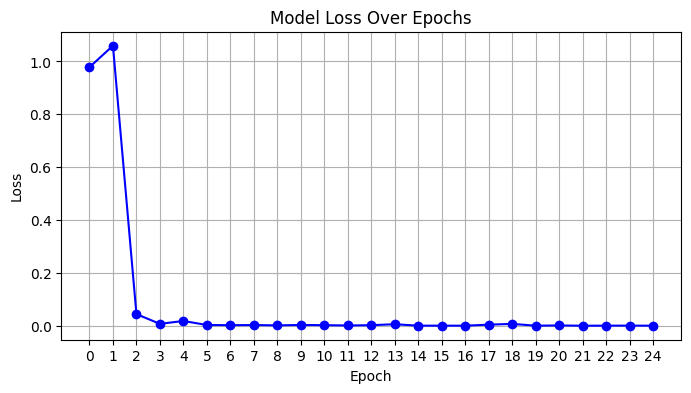

In [38]:
# Plotting the graph
total_loss = [tensor.detach().cpu().numpy() for tensor in total_loss]
plt.figure(figsize=(8, 4))
plt.plot(total_loss, marker='o', color='blue')
plt.xticks(range(len(total_loss)))
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [39]:
from torch.distributions.one_hot_categorical import OneHotCategorical
import itertools
@torch.no_grad()
def predict(dataset, model, seed, midis, device, num_words=20):

    if len(midis)<num_words:
      midis = list(itertools.islice(itertools.cycle(midis), num_words))

    def concat(word, midi):
      return torch.cat([torch.tensor(word), torch.tensor(midi)], dim=-1)

    model.eval()

    words = [dataset.inv_embds[tuple(seed)]]

    word = seed
    i = 0
    while i < num_words-1:
        midi = midis[i]
        init_word = word.copy()
        word = concat(word, midi)
        word = word.reshape(1,1,305)
        x = word
        x = x.to(device)

        y_pred = model(x)

        dist = OneHotCategorical(logits=y_pred)
        probs = dist.probs
        _, top_10_indices = torch.topk(probs, 10)

        if i==0:
          token = top_10_indices.view(10)[random.randint(0, 9)].item()
          words.append(dataset.inv_vocab[token])
          word = dataset.embds[token]
          i += 1
          continue
        token = top_10_indices.view(10)[random.randint(0,9)].item()
        if dataset.inv_vocab[token] == words[-1]:
          word = init_word
          continue
        word = dataset.embds[token]
        words.append(dataset.inv_vocab[token])
        i += 1


    return words

In [46]:
dfs = []
for i in range(5):
  song_num = i
  # seed_word = train_dataset.embds[test_data['lyrics'][song_num][0]]
  for word in ["love", "smoke", "children"]:
    df = {"artist":[],"song_name":[],"lyrics":[]}
    seed_word = train_dataset.w2v[word]
    midi_feats = test_dataset.midi[list(test_dataset.midi.keys())[song_num]]
    print(test_data['artists'][song_num], '|' ,test_data['song_names'][song_num],  '|', word)
    df["artist"].append(test_data['artists'][song_num])
    df["song_name"].append(test_data['song_names'][song_num])
    df["lyrics"].append(" ".join(predict(train_dataset, model, seed_word, midi_feats ,device, num_words=50)))
    dfs.append(df)

the bangles | eternal flame | love
the bangles | eternal flame | smoke
the bangles | eternal flame | children
billy joel | honesty | love
billy joel | honesty | smoke
billy joel | honesty | children
cardigans | lovefool | love
cardigans | lovefool | smoke
cardigans | lovefool | children
aqua | barbie girl | love
aqua | barbie girl | smoke
aqua | barbie girl | children
blink 182 | all the small things | love
blink 182 | all the small things | smoke
blink 182 | all the small things | children


In [ ]:
all = pd.DataFrame()
for data in dfs:
  all = all.append(pd.DataFrame(data))

Here are a few examples of genereating new lyrics based on the artist, the song's MIDI data and the seed word:

In [48]:
all

,artist,song_name,lyrics
0,the bangles,eternal flame,love daddy baby child son mother mama son sons...
0,the bangles,eternal flame,smoke mist slowly faster harder lot nothing no...
0,the bangles,eternal flame,children child she really yeah yes hey crazy d...
0,billy joel,honesty,love play stay relax fun relax stay leave leav...
0,billy joel,honesty,smoke burn shoot pull hang pull turn move him ...
0,billy joel,honesty,children daughter lola happiness karma somehow...
0,cardigans,lovefool,love love daddy til until if though only just ...
0,cardigans,lovefool,smoke smoke fire man men people here we going ...
0,cardigans,lovefool,children daughters sisters sister after star t...
0,aqua,barbie girl,love beautiful wonderful beautiful loved knew ...
